# Generating orientation dataset with halotools

In this notebook, we will be using the halo model-based intrinsic alignment model developed by Nick Van Alfen in Van Alfen et al. (in prep).



## Step I: Defining the halo model

In [1]:
# Uncomment to download the halo catalog
# from halotools.sim_manager import DownloadManager
# dman = DownloadManager()
# dman.download_processed_halo_table('bolshoi', 'rockstar', 0)

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [4]:
from halotools.empirical_models import HodModelFactory

# define the central occupatoion model
from halotools.empirical_models import TrivialPhaseSpace, Zheng07Cens
cens_occ_model =  Zheng07Cens()
cens_prof_model = TrivialPhaseSpace()

# define the satellite occupation model
from halotools.empirical_models import Zheng07Sats
from halotools.empirical_models import NFWPhaseSpace, SubhaloPhaseSpace


sats_occ_model =  Zheng07Sats()
sats_prof_model = SubhaloPhaseSpace('satellites', np.logspace(10.5, 15.2, 15))

# define the alignment models
from halotools.empirical_models.ia_models.ia_model_components import CentralAlignment,\
    RadialSatelliteAlignment

central_orientation_model = CentralAlignment(central_alignment_strength=1.0)
satellite_orientation_model = RadialSatelliteAlignment(satellite_alignment_strength=1.0)

# combine model components
model_instance = HodModelFactory(centrals_occupation = cens_occ_model,
                                 centrals_profile = cens_prof_model,
                                 satellites_occupation = sats_occ_model,
                                 satellites_profile = sats_prof_model,
                                 centrals_orientation = central_orientation_model,
                                 satellites_orientation = satellite_orientation_model,
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'centrals_orientation',
                                 'satellites_orientation')
                                )

In [5]:
# populate mock catalog
model_instance.populate_mock(halocat)
print("number of galaxies: ", len(model_instance.mock.galaxy_table))

# For testing purposes, we are only going to keep halos with several satelittes
m = model_instance.mock.galaxy_table['halo_num_satellites'] > 5

galaxy_table = model_instance.mock.galaxy_table[m]

# Scaling mass 
galaxy_table['mass_scaled'] = log10(galaxy_table['halo_mvir_host_halo']) 
print("number of galaxies after filtering: ", len(galaxy_table))

number of galaxies:  74766
number of galaxies after filtering:  4249


/home/francois/repo/halotools/halotools/empirical_models/ia_models/ia_model_components.py:190: UserWarning: `central_alignment_strength` not detected in the table, using value in self.param_dict.
  warn(msg)
/home/francois/repo/halotools/halotools/empirical_models/ia_models/ia_model_components.py:520: UserWarning: `satellite_alignment_strength` key not detected in `table`.The value set in self.param_dict of this class will be used instead.
  warn(msg)


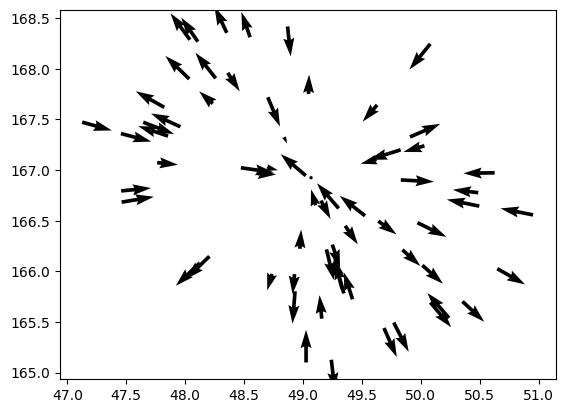

In [6]:
# Ok, very good, now, let's visualize a given halo
m = galaxy_table['halo_hostid'] == 3061174745
halo1 =  galaxy_table[m]
quiver(halo1['x'], halo1['y'],
       halo1['galaxy_axisA_x'], 
       halo1['galaxy_axisA_y'])

## Step II: Create batches of graphs from this catalog

In [7]:
import jax
import jax.numpy as jnp
from functools import partial
import haiku as hk
import jax
import jax.numpy as jnp
import jraph
import optax

from deepghc.dataset import get_batch_fn

In [8]:
batch_fn = get_batch_fn(galaxy_table, 
                                vector_keys=['x', 'y', 'z', 
                                             'galaxy_axisA_x', 'galaxy_axisA_y', 'galaxy_axisA_z',
                                             'galaxy_axisB_x', 'galaxy_axisB_y', 'galaxy_axisB_z',
                                             'galaxy_axisC_x', 'galaxy_axisC_y', 'galaxy_axisC_z',],
                                scalar_keys=['mass_scaled'],
                                context_keys=['mass_scaled']
                               )

Precomputing dataset


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Done


In [32]:
batch_init = batch_fn(jax.random.PRNGKey(18))
batch_init = jax.tree_map(lambda x:x[0], batch_init)

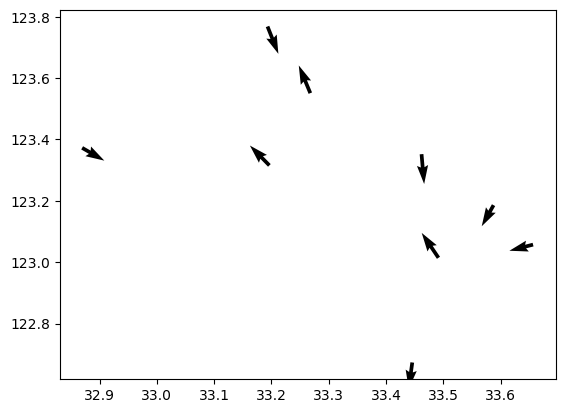

In [33]:
m = batch_init.nodes['pos'][:,0]>0
quiver(batch_init.nodes['pos'][:,0][m],
       batch_init.nodes['pos'][:,1][m],
       batch_init.nodes['vectors'][:,1,0][m],
       batch_init.nodes['vectors'][:,1,1][m])

In [101]:
def EGCL(graph):
    """ Equivariant Graph Layer expects nodes with x, and h
    """
    v = graph.nodes['v']
    h = graph.nodes['h']
    n_features = h.shape[-1]

    d_ij = jnp.sqrt(jnp.sum((v[graph.senders] - v[graph.receivers])**2, axis=-1).reshape([-1, v.shape[-2]]))

    
    m_ij = hk.nets.MLP([n_features, n_features], activation=jax.nn.leaky_relu)(
            jnp.concatenate([h[graph.senders], 
                             h[graph.receivers],
                             d_ij**2, 
                             graph.edges.reshape([-1,1])] ,axis=-1)
            )
    # Attention weight
    e_ij = jax.nn.sigmoid(hk.Linear(1)(m_ij))

    # Updating latents
    new_h = jax.nn.leaky_relu(hk.Linear(n_features)(
            jnp.concatenate([
                h, 
                jraph.segment_sum( e_ij*m_ij, graph.receivers, num_segments=70)
            ], axis=-1)))
    new_h = h + hk.Linear(n_features)(new_h)

    # Updating vectors (but not the position)
    d_ij = jnp.sqrt(jnp.sum((v[graph.senders] - v[graph.receivers])**2, axis=-1).reshape([-1, v.shape[-2]]))
    d = (v[graph.senders] - v[graph.receivers])/(d_ij.reshape([-1, v.shape[-2], 1]) + 1)
    v_ij = hk.nets.MLP([n_features, n_features], activation=jax.nn.leaky_relu)(
            jnp.concatenate([h[graph.senders], 
                             h[graph.receivers],
                             d_ij**2, 
                             graph.edges.reshape([-1,1])], axis=-1)
            )
    v_ij = hk.Linear(v.shape[-2])(v_ij).reshape([-1, v.shape[-2], 1])
    v = v + jraph.segment_sum(d * v_ij, graph.receivers, num_segments=70)
    return graph._replace(nodes={'v': v,
                                 'h': h})

In [111]:
def network_definition(graph: jraph.GraphsTuple) -> jraph.ArrayTree:
    
    # We make a distinction between position x and other vectors v
    graph = graph._replace(nodes={'v': graph.nodes['vectors'], 
                                  'h': graph.nodes['scalars']})
    
    # Expending the dimensionality of hidden features
    graph = graph._replace(nodes={'v': graph.nodes['v'], 
                                  'h': hk.Linear(16)(graph.nodes['h'])})
    
    graph = EGCL(graph)
    
    # Applying a score network on the ouput of the EGCL
    v = graph.nodes['v'][:,1:].reshape([-1,9])
    h = graph.nodes['h']
    net = hk.nets.MLP([256, 256, 256], activation=jax.nn.leaky_relu)(jnp.concatenate([v,h], axis=-1))
    
    score = hk.Linear(3)(net)
    
    return graph._replace(nodes={**(graph.nodes), 'score': score})

In [112]:
network = hk.without_apply_rng(hk.transform(network_definition))
batch_init = batch_fn(jax.random.PRNGKey(42))
#Removing the batch dimension
batch_init = jax.tree_map(lambda x:x[0], batch_init)
params = network.init(jax.random.PRNGKey(42), batch_init)

In [113]:
from jaxlie import SO3
from so3dm.distributions import IsotropicGaussianSO3

In [114]:
@jax.vmap
def noise_fn1(u, key):
    x = SO3.from_matrix(u)
    dist = IsotropicGaussianSO3(x, 0.2)
    qn = dist.sample(seed=key)
    
    def fn(s,q):
        return dist.log_prob( (SO3(q) @ SO3.exp(s)).wxyz)
    
    score = jax.grad(fn)(jnp.zeros(3), qn)
    return {'vn': SO3(qn).as_matrix(), 'score': score}

@jax.jit
@jax.vmap
def noise_fn(u, key):
    return noise_fn1(u, jax.random.split(key, 70))

In [117]:
@jax.jit
@partial(jax.vmap, in_axes=[None, 0])
def prediction_loss(params, batch):
    decoded_nodes = network.apply(params, batch)
    
    loss = jnp.sum((decoded_nodes.nodes['score'] - batch.nodes['score'])**2, axis=-1)
    loss = decoded_nodes._replace(nodes=loss)
    
    # We create a mask to not consider the output of useless nodes
    loss = jraph.zero_out_padding(loss)
    
    # We interpret the decoded nodes as a pair of logits for each node.
    return jnp.mean( loss.nodes )

@jax.jit
def update(params, opt_state, batch):
    l, g = jax.value_and_grad(lambda a,b:prediction_loss(a,b).mean())(params, batch)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state, l

In [118]:
opt_init, opt_update = optax.adam(1e-4)
opt_state = opt_init(params)
seed = jax.random.PRNGKey(0)
losses = []

In [151]:
for step in range(100):
    seed, key, key2 = jax.random.split(seed, 3)
    # Draw a batch of graphs
    batch = batch_fn(key)
    # Add noise to graphs
    bn = noise_fn(batch.nodes['vectors'][:,:,1:], jax.random.split(key2, 32 ))
     
    batch = batch._replace(nodes={'scalars': batch.nodes['scalars'],
                                 'vectors': jnp.concatenate([
                                     batch.nodes['vectors'][:,:,0:1],
                                     bn['vn']],axis=-2),
                                 'true_vectors': batch.nodes['vectors'],
                                 'score': bn['score']})
    
    params, opt_state, l = update(params, opt_state, batch)
    losses.append(l)

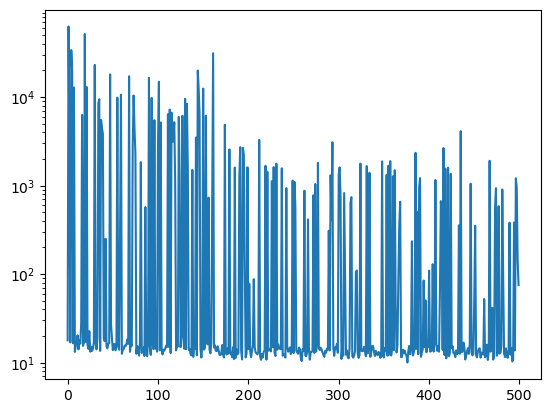

In [157]:
semilogy(losses)

In [159]:
batch.nodes['score'].max()

Array(19.176847, dtype=float32)

In [153]:
batch.nodes['vectors'][0,0]

Array([[35.72499   , 43.2765    , 17.71299   ],
       [ 0.6391578 , -0.72344905,  0.2609575 ],
       [ 0.67182463,  0.36005455, -0.6473117 ],
       [ 0.37433806,  0.58905196,  0.7161626 ]], dtype=float32)

In [154]:
res = jax.vmap(lambda x: network.apply(params, x))(batch)

In [155]:
res.nodes['score'][0,0]

Array([ 0.04017361, -0.7496088 ,  0.6311837 ], dtype=float32)

In [156]:
batch.nodes['score'][0,0]

Array([  3.232463 ,  -0.7407868, -10.853577 ], dtype=float32)

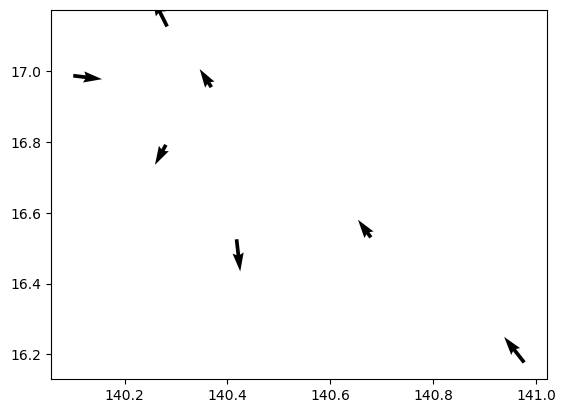

In [99]:
m = batch.nodes['pos'][0,:,0]>0
quiver(batch.nodes['pos'][0,:,0][m], 
       batch.nodes['pos'][0,:,1][m], 
       batch.nodes['vectors'][0,:,1,0][m], 
       batch.nodes['vectors'][0,:,1,1][m])

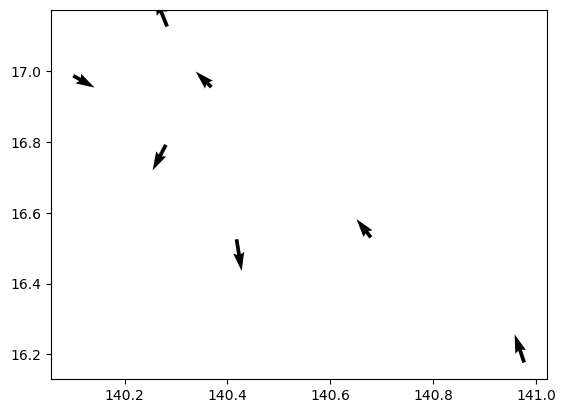

In [100]:
m = batch.nodes['pos'][0,:,0]>0
quiver(batch.nodes['pos'][0,:,0][m], 
       batch.nodes['pos'][0,:,1][m], 
       bn['vn'][0,:,0,0][m], 
       bn['vn'][0,:,0,1][m])

In [94]:
batch.nodes['vectors'].shape

(32, 70, 4, 3)

In [17]:
for step in range(100):
    seed, key = jax.random.split(seed)
    batch = batch_fn(key)
    params, opt_state, l = update(params, opt_state, batch)
    losses.append(l)

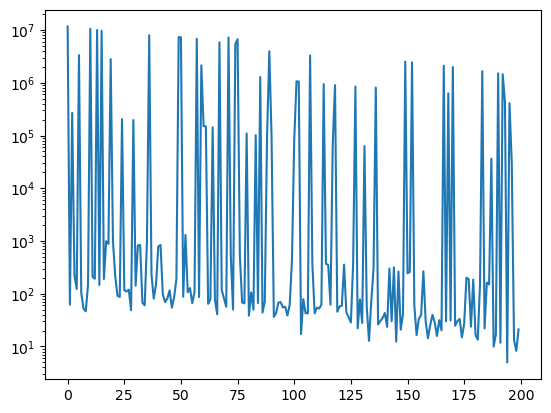

In [18]:
semilogy(losses)